The goal of this notebook is to calibrate the diffusion denoiser on a new dataset, then run a low-dim embedding on the denoised data, do a UMAP, then clustering. Grab those clusters and use as the basis for a synthetic dataset for the pairwise problem.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scanpy as sc

from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd

from sklearn.metrics import mean_squared_error

from molecular_cross_validation import util as ut
from molecular_cross_validation.mcv_sweep import GridSearchMCV
from molecular_cross_validation.scripts.diffusion_sweep import compute_diff_op

# Standard Workflow

In [2]:
def load_pbmc():
    adata = sc.read_10x_h5('/Users/josh/Downloads/5k_pbmc_v3_filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.filter_genes(adata, min_cells=20)
    adata.X = np.array(adata.X.todense())
    return adata

In [3]:
def load_kidney():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/tabula-muris-senis/tabula-muris-senis-droplet-processed-official-annotations-Kidney.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    adata.X = np.array(adata.X.todense())
    return adata

In [4]:
def load_citeseq():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/citeseq/bm.cite.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    adata.X = np.array(adata.X.todense())
    return adata

In [5]:
kidney = load_kidney()

In [ ]:
kidney.obs['age'] = adata.obs['mouse.id'].apply(lambda x: x.split('-')[0])
pd.crosstab(kidney.obs['cell_ontology_class'], kidney.obs['age'])

In [6]:
adata = kidney.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=None, min_disp=0.5)

highly_variable_genes = adata.var.highly_variable

adata = adata[:, adata.var.highly_variable]

In [7]:
sc.pp.scale(adata, max_value=10, zero_center=False)

/Users/josh/src/scanpy/scanpy/preprocessing/_simple.py:870: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.tl.pca(adata, n_comps=100, zero_center=False, random_state = 1)

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 20]

Number of PCs matters for the UMAP

In [34]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_20')

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


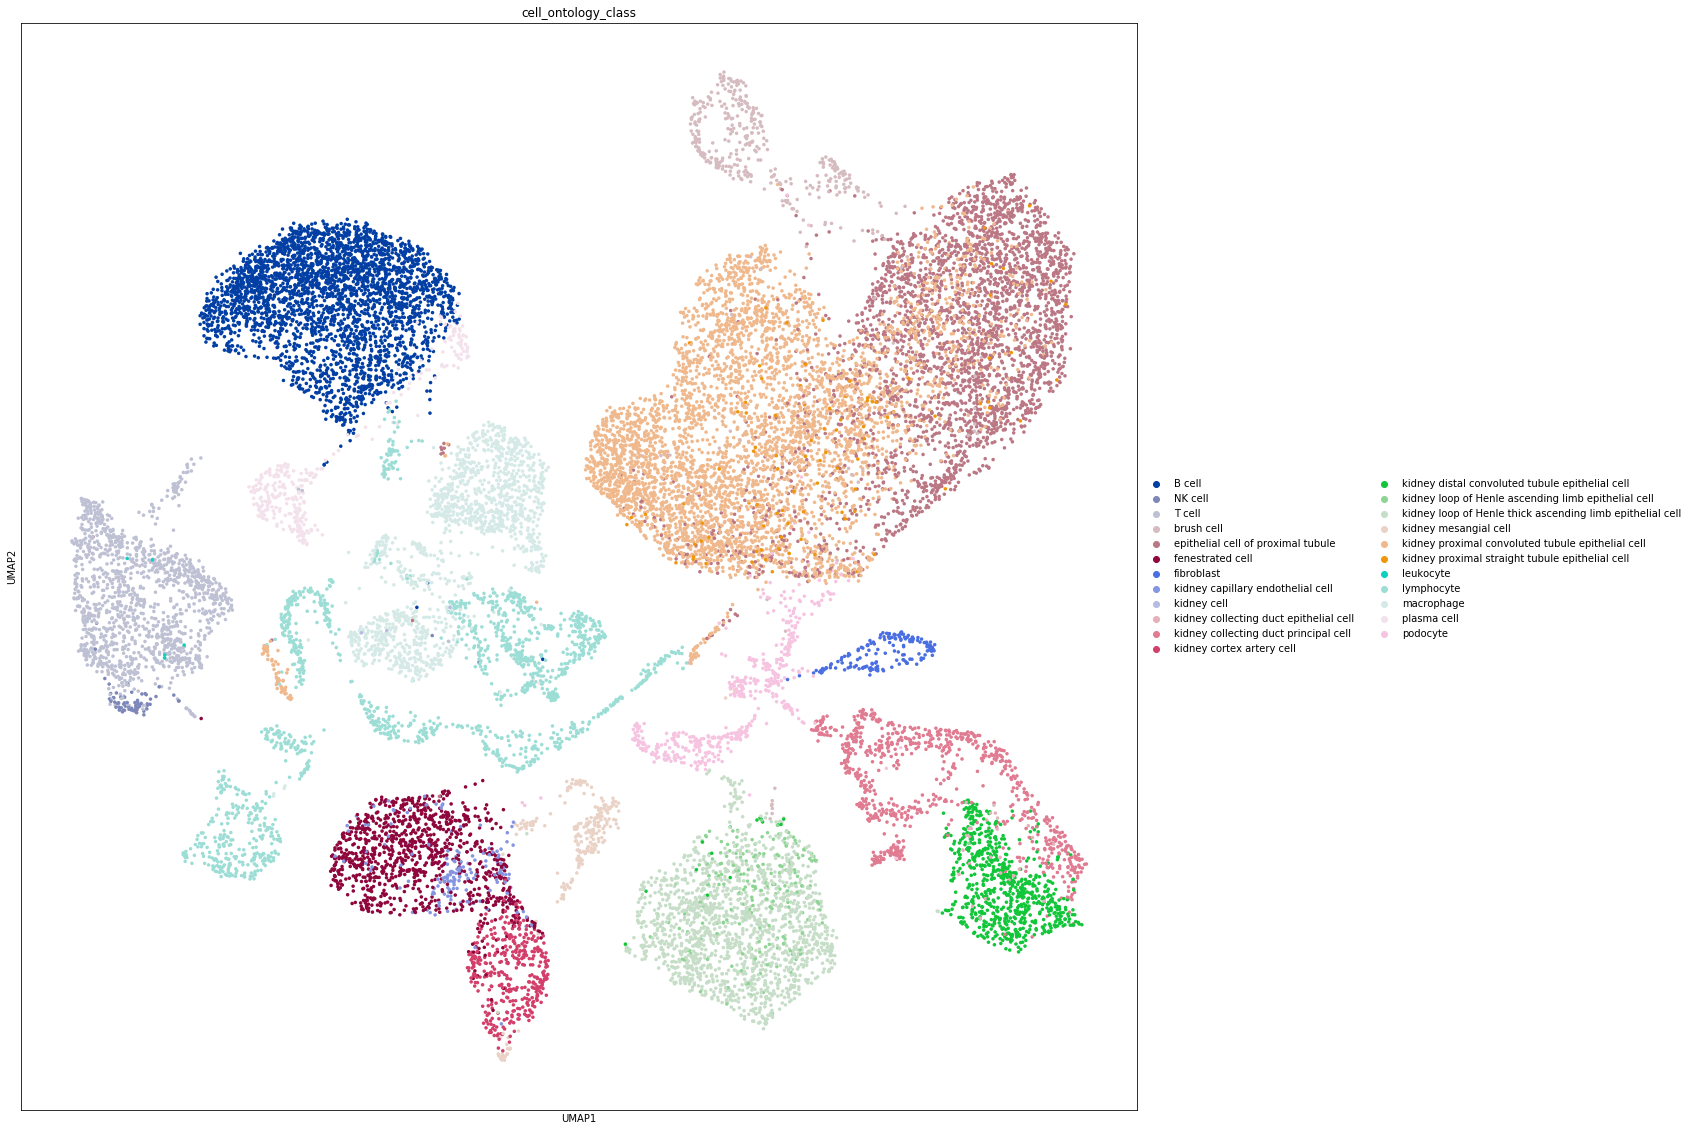

In [11]:
sc.pl.umap(adata, color='cell_ontology_class', size=50)

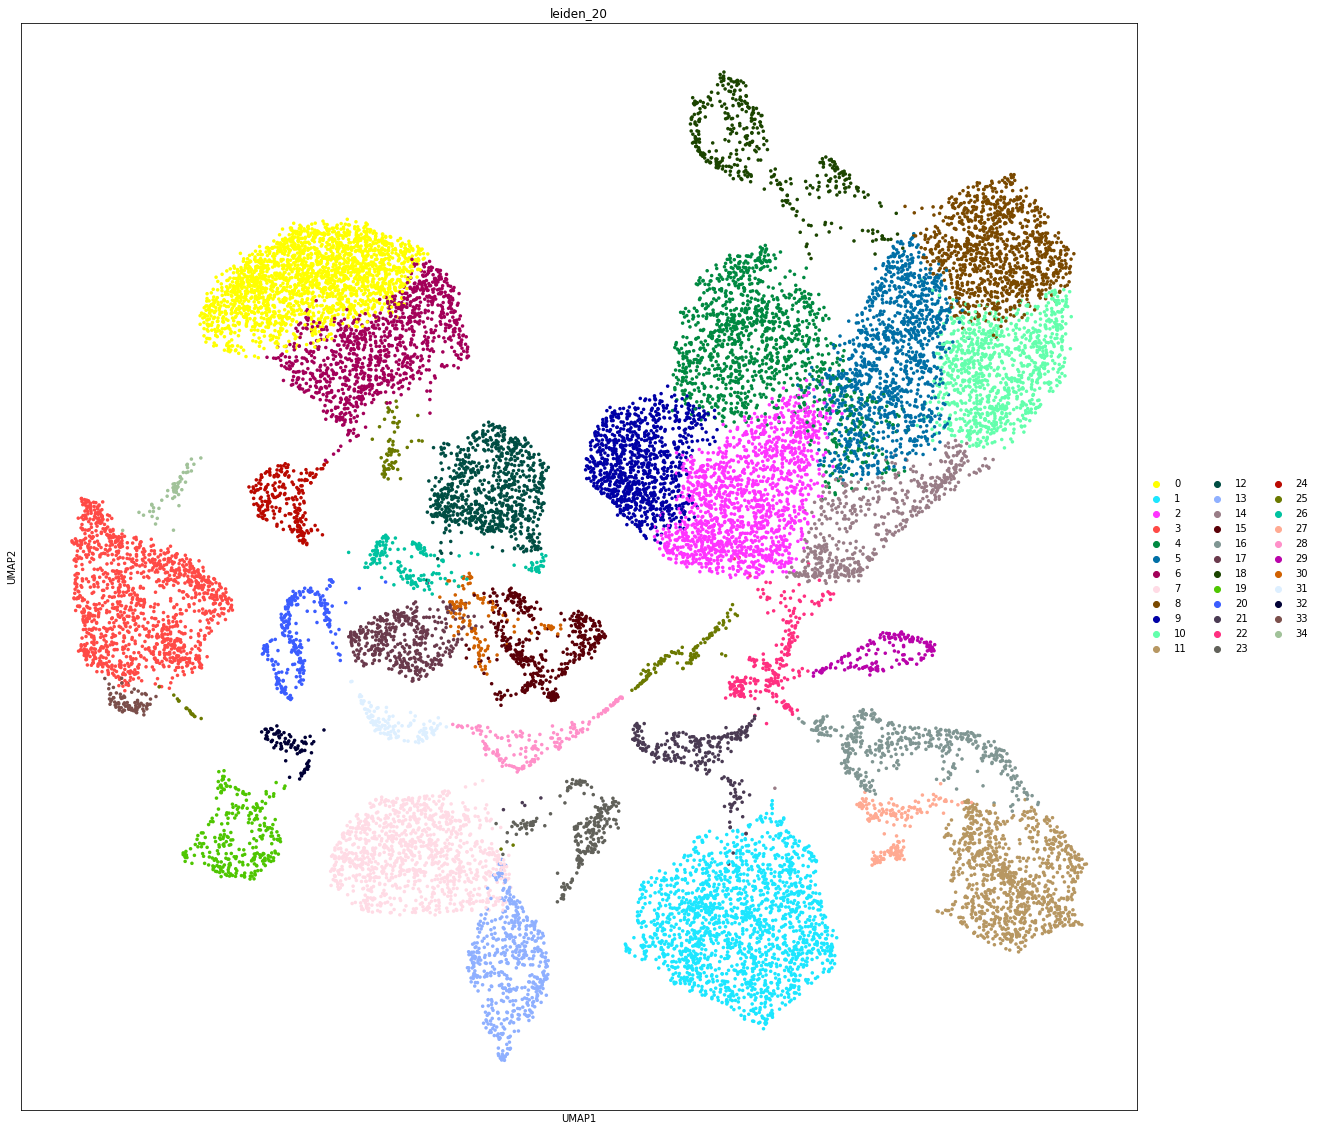

In [36]:
sc.pl.umap(adata, color='leiden_20', size=50)

In [70]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=70)
sc.tl.leiden(adata, key_added='leiden_70')
sc.tl.leiden(adata, resolution = 0.5, key_added='leiden_70_0.5')
sc.tl.umap(adata)

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


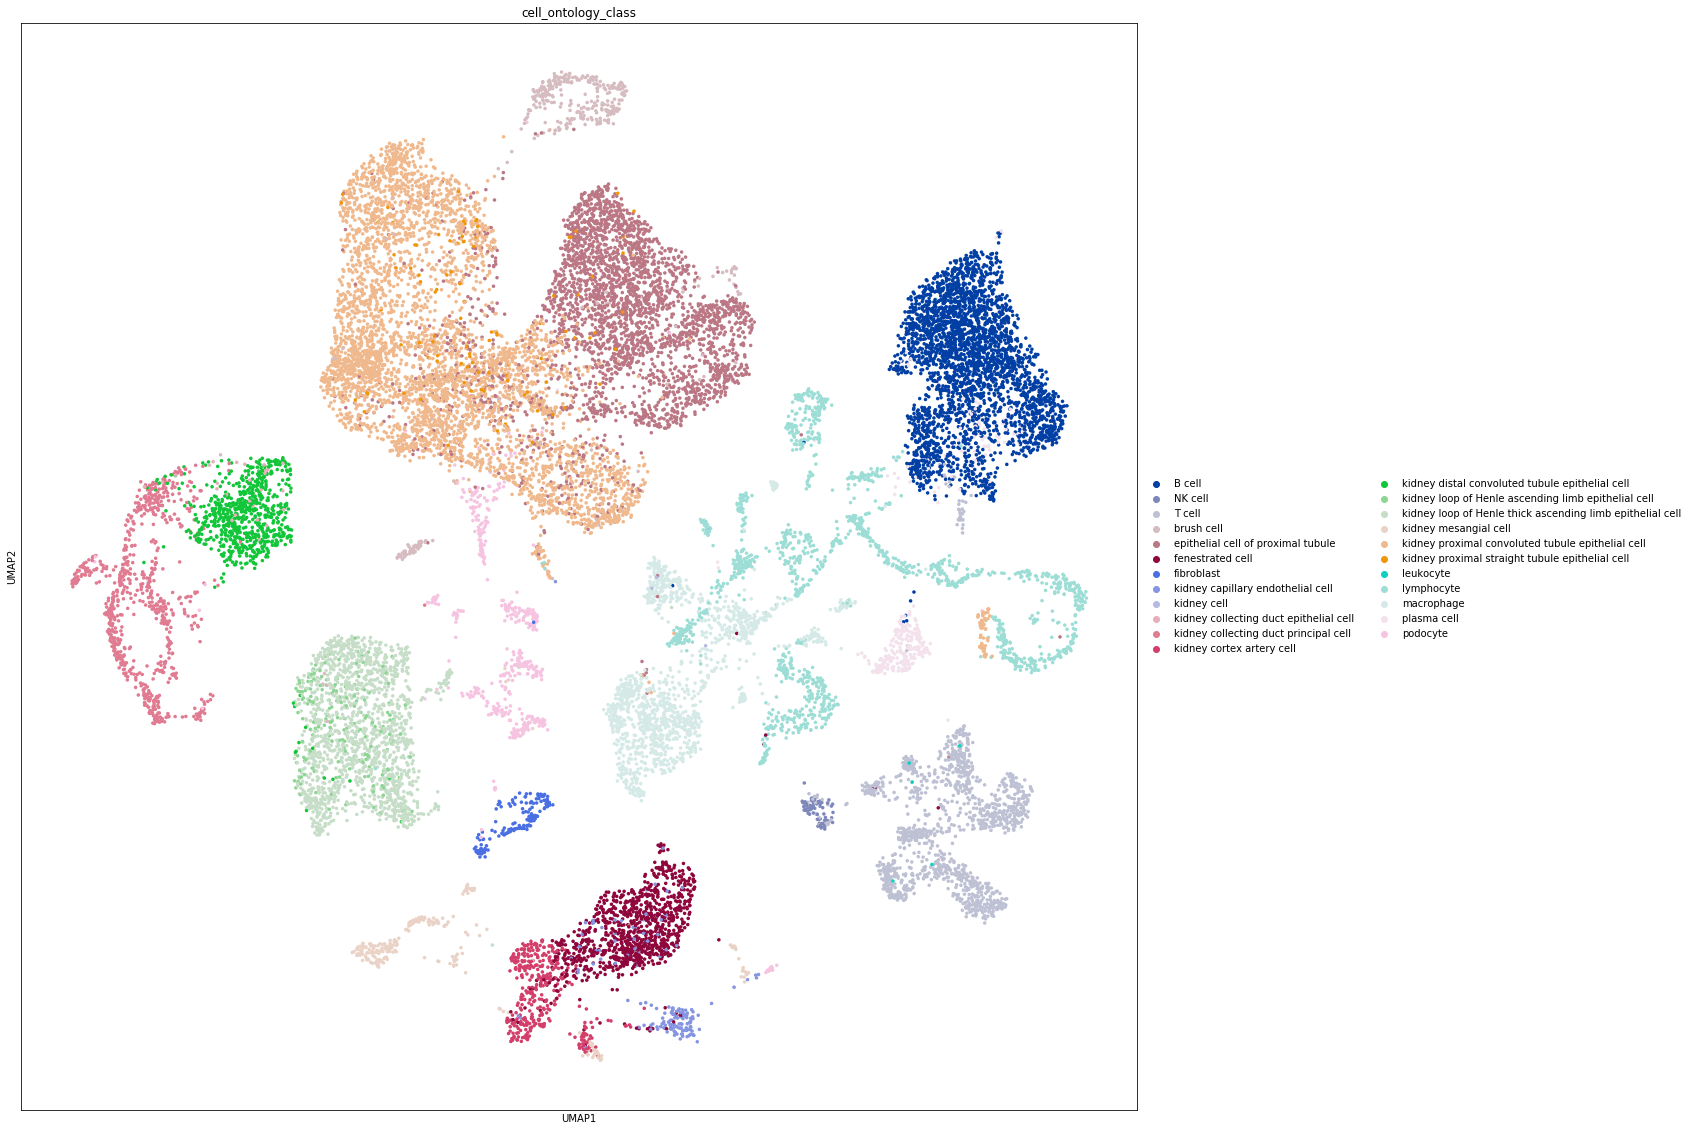

In [13]:
sc.pl.umap(adata, color='cell_ontology_class', size=50)

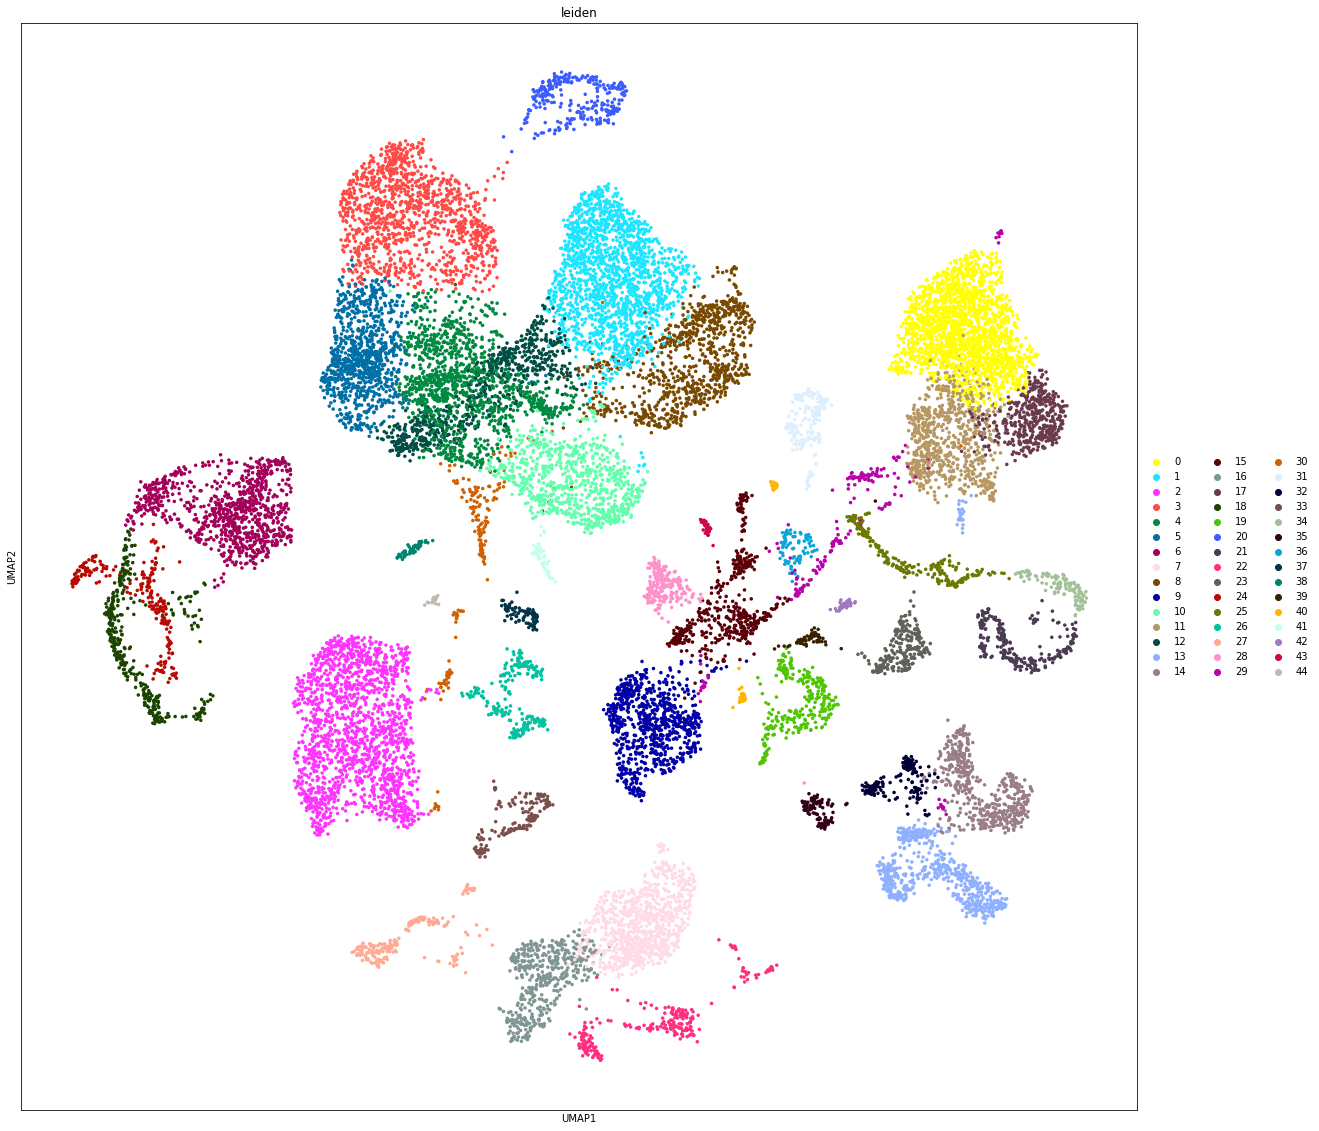

In [29]:
sc.pl.umap(adata, color='leiden', size=50)

Because the clusters computed are more refined than the cell type labels, we map each cluster to the most frequent label. We then compute the ARI of the cluster-induced labels and the ground-truth labels.

In [80]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd

def clust_to_label(clusters, labels):
    "Given a clustering and a labeling, map each cluster to its most frequent label."
    ct = pd.crosstab(clusters, labels)
    consensus_label = np.argmax(pd.crosstab(clusters, labels).values, axis = 1)
    remapper = dict(zip(ct.index, ct.columns[consensus_label]))
    new_labels = clusters.map(remapper)
    return new_labels
def induced_label_ari(clusters, labels):
    return adjusted_rand_score(clust_to_label(clusters, labels), labels)

In [91]:
for key in ['leiden_20', 'leiden_70', 'leiden_70_0.5']:
    ari = adjusted_rand_score(adata.obs[key], adata.obs['cell_ontology_class'])
    induced_ari = induced_label_ari(adata.obs[key], adata.obs['cell_ontology_class'])
    print(f'{key}\tInduced ARI: {induced_ari:.2}\tARI: {ari:.2}\tN Clusters:{len(adata.obs[key].unique())}')

leiden_20	Induced ARI: 0.78	ARI: 0.49	N Clusters:35
leiden_70	Induced ARI: 0.84	ARI: 0.47	N Clusters:45
leiden_70_0.5	Induced ARI: 0.83	ARI: 0.63	N Clusters:32


More PCs gave a better induced ARI. (And a better absolute ARI if lower resolution is used.)

We may search more systematically:

In [108]:
outcomes = {}
for n_pcs in [10, 20, 30, 40, 50, 60, 70]:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    for resolution in [0.5, 0.75, 1]:
        key = f'leiden_{n_pcs}_{resolution}'
        sc.tl.leiden(adata, resolution = resolution, key_added=key)
        outcomes[key] = induced_label_ari(adata.obs[key], adata.obs['cell_ontology_class'])
        print(key, outcomes[key])

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_10_0.5 0.6378746655665612
leiden_10_0.75 0.6475127070062493
leiden_10_1 0.7054276044195015


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_20_0.5 0.7938596967828507
leiden_20_0.75 0.7875640769722151
leiden_20_1 0.7768843261991294


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_30_0.5 0.782258077721645
leiden_30_0.75 0.8021185406469831
leiden_30_1 0.8077580440362054


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_40_0.5 0.8319783730556014
leiden_40_0.75 0.8412106710841017
leiden_40_1 0.8342726443641021


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_50_0.5 0.8356834893030178
leiden_50_0.75 0.8361332412937359
leiden_50_1 0.8324706506249604


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_60_0.5 0.8337254008914359
leiden_60_0.75 0.8446029722793359
leiden_60_1 0.8493224966790373


/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


leiden_70_0.5 0.8252805990997193
leiden_70_0.75 0.8430577390554639
leiden_70_1 0.8441920916509549


In [97]:
from collections import Counter
def find_missing(clusters, labels):
    induced_label_frequencies = Counter(clust_to_label(clusters, labels))
    label_frequencies = Counter(adata.obs['cell_ontology_class'])
    for label in label_frequencies:
        if label not in induced_label_frequencies:
            print(f"Lost {label_frequencies[label]} of {label}")

Some types may be lost entirely!

In [96]:
for key in ['leiden_20', 'leiden_70', 'leiden_70_0.5']:
    print(key)
    find_missing(adata.obs[key], adata.obs['cell_ontology_class'])

leiden_20
Lost 201 of kidney loop of Henle ascending limb epithelial cell
Lost 161 of kidney capillary endothelial cell
Lost 95 of kidney proximal straight tubule epithelial cell
Lost 25 of kidney collecting duct epithelial cell
Lost 5 of leukocyte
Lost 3 of kidney cell
leiden_70
Lost 201 of kidney loop of Henle ascending limb epithelial cell
Lost 95 of kidney proximal straight tubule epithelial cell
Lost 25 of kidney collecting duct epithelial cell
Lost 5 of leukocyte
Lost 3 of kidney cell
leiden_70_0.5
Lost 201 of kidney loop of Henle ascending limb epithelial cell
Lost 381 of kidney cortex artery cell
Lost 95 of kidney proximal straight tubule epithelial cell
Lost 25 of kidney collecting duct epithelial cell
Lost 5 of leukocyte
Lost 3 of kidney cell


Note that "kidney loop of Henle ascending limb epithelial cell" is lost to the much more common "kidney loop of Henle thick ascending limb epithelial cell". The primary difference is that at 70, one rescues the "kidney proximal straight tubule epithelial cell" subpopulation.

# MCV for PCA

Given a normalization scheme, do a 50-50 split for MCV.

In [13]:
def recipe_seurat(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    return adata

def recipe_sqrt(adata):
    sc.pp.sqrt(adata)
    return adata

def recipe_log(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    return adata

def mcv_pca(adata, recipe, max_pcs = 30):
    assert adata.X.dtype == np.int
    
    from scipy.sparse import issparse
    assert not issparse(adata.X)
    
    adata1 = adata.copy()
    adata2 = adata.copy()
    adata1.X = np.random.binomial(adata.X, 0.5).astype(np.float)
    adata2.X = adata.X - adata1.X
    
    adata1 = recipe(adata1)
    adata2 = recipe(adata2)
    
    sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)
    
    k_range = np.arange(2, max_pcs, 2)
    mcv_loss = np.zeros(len(k_range))
    rec_loss = np.zeros(len(k_range))
        
    for i, k in enumerate(k_range):
        reconstruction = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
        mcv_loss[i] = mean_squared_error(reconstruction, adata2.X)
        rec_loss[i] = mean_squared_error(reconstruction, adata1.X)
    
    return k_range, mcv_loss, rec_loss

In [14]:
adata = kidney[:,highly_variable_genes].copy()
adata.X = np.array(adata.X.copy()).astype(np.int)

In [15]:
matplotlib.rcParams['figure.figsize'] = [6.4, 4.8]

Text(0.5, 1.0, 'MCV for Seurat Normalization')

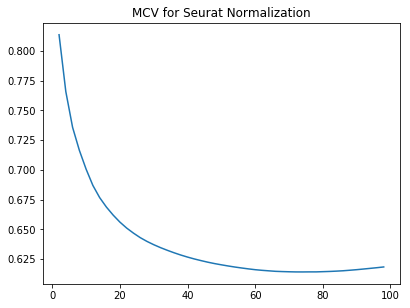

In [16]:
k_range, mcv_loss, rec_loss = mcv_pca(adata, recipe_seurat, max_pcs=100)
plt.plot(k_range, mcv_loss)
plt.title("MCV for Seurat Normalization")

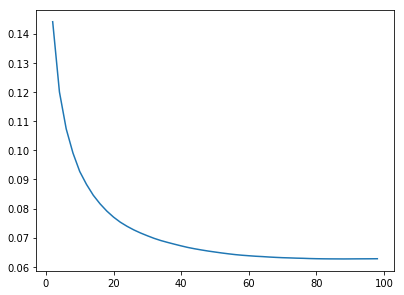

In [17]:
k_range, mcv_loss, rec_loss = mcv_pca(adata, recipe_sqrt, max_pcs=100)
plt.plot(k_range, mcv_loss)

Different normalization schemes do select different numbers of PCs.

Moreover, the sharpness/flatness of the basin does depend significantly on which recipe is used.

# Dependency on SNR

Downsample, and see how optimal number of PCs varies.

In [18]:
adata = load_pbmc()
adata.X = adata.X.astype(np.int)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.


In [19]:
ratio = np.arange(0.2, 1.2, 0.2)
total_counts = adata.X.sum()
mcv_losses = []

for r in ratio:
    adata_down = sc.pp.downsample_counts(adata, total_counts = int(r*total_counts), copy=True)
    k_range, mcv_loss, rec_loss = mcv_pca(adata_down, recipe_seurat)
    mcv_losses.append(mcv_loss)

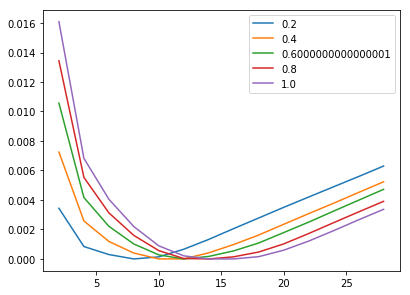

In [20]:
for i, r in enumerate(ratio):
    plt.plot(k_range, mcv_losses[i] - min(mcv_losses[i]), label=r)
plt.legend()

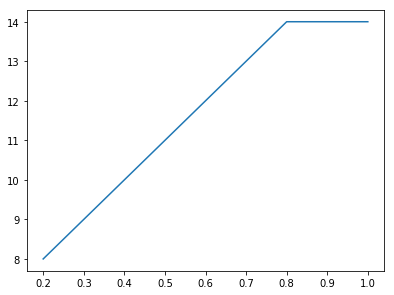

In [21]:
plt.plot(ratio, [k_range[np.argmin(mcv_loss)] for mcv_loss in mcv_losses])